In [19]:
from gensim.models import word2vec
import multiprocessing
import os
import nltk
import pandas as pd
import re
import time
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
#nltk.download('stopwords')

In [20]:
STOP_WORDS = nltk.corpus.stopwords.words()

In [21]:
data = pd.read_csv('./data/train.csv').sample(50000, random_state=23)
#data = pd.read_csv('./data/train.csv')
print(data.shape)

(50000, 6)


#### Define functions for cleaning sentences and dataframes

In [22]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence


def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

#### Fetch clean data

In [23]:
tic = time.time()
data = clean_dataframe(data)
toc = time.time()
duration = str(round((toc -tic)))
print('Time taken to clean the dataset: '+duration+' Second(s)')
data.head(5)

Time taken to clean the dataset: 27 Second(s)


,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,sex necessary relationship,sex important good relationship,1
181001,181001,277377,277378,inspiring start stories,inspirational stories ever,0
294691,294691,150129,93109,best way digital marketing,best unique ways digital marketing,1
104145,104145,171986,171987,best way grow facebook fan page,get followers facebook page,1
357893,357893,487310,487311,suppose host sends two tcp segments back back ...,suppose host sends two tcp segments back back ...,1


#### prepare gensim-friendly data, that is iterable list of sentences

In [24]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

In [25]:
corpus = build_corpus(data)        
corpus[0:2]

[['sex', 'necessary', 'relationship'], ['inspiring', 'start', 'stories']]

### Word 2 Vec
The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)

In [26]:
quora_model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [27]:
quora_model.most_similar('python', topn=5)

[('java', 0.9775066375732422),
 ('learning', 0.9489894509315491),
 ('programming', 0.9107973575592041),
 ('learn', 0.8568311929702759),
 ('code', 0.8433310985565186)]

In [28]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

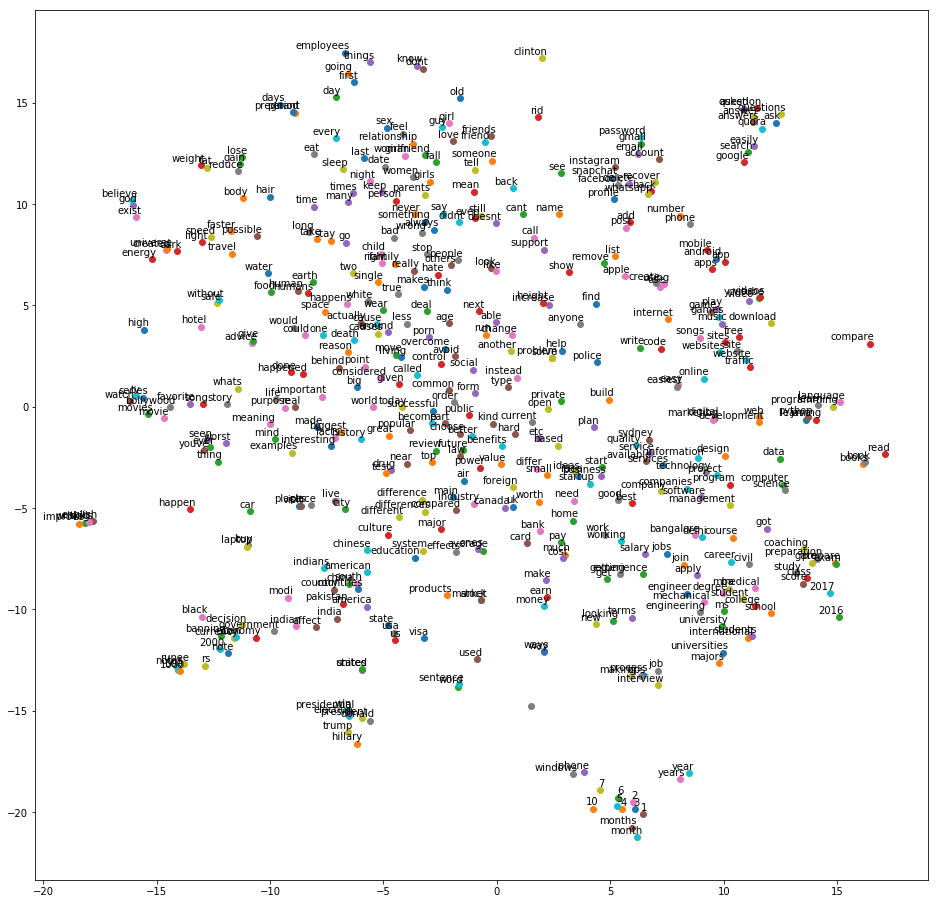

In [29]:
tsne_plot(quora_model)

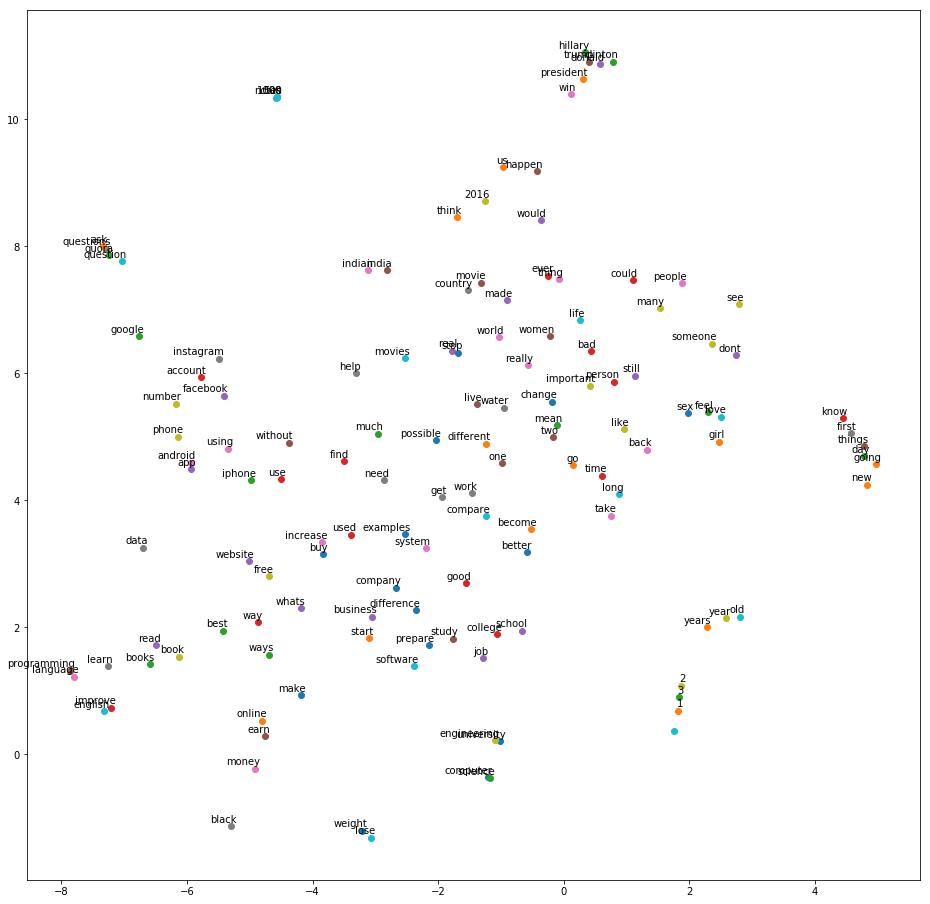

In [30]:
# A more selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

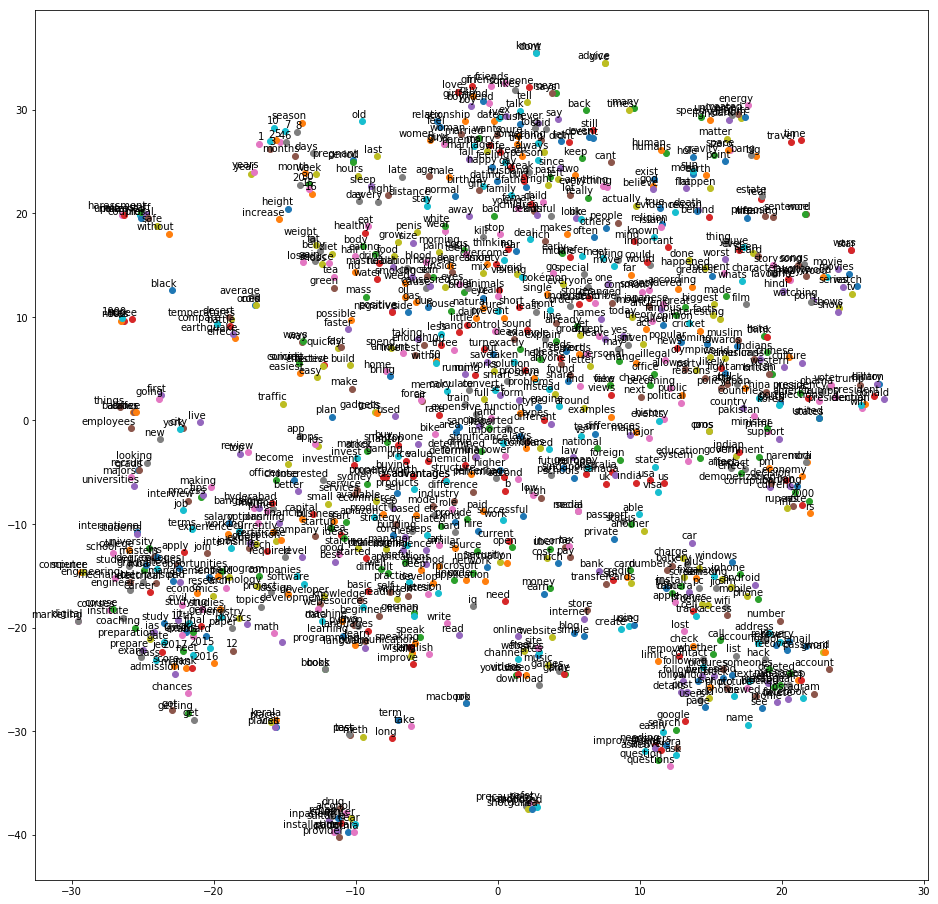

In [31]:
# A less selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
tsne_plot(model)